# Appendix K: Real-World Reasoning Tasks with Momentum Augmentation

---

## Scientific Question

Appendices-H/I/J validated the Low-Pass Induction Filter on synthetic tasks.  
**Does momentum augmentation help on REAL reasoning tasks?**

| Task | Sequential Dependency | Predicted Benefit |
|------|----------------------|------------------|
| Arithmetic Carry | Carry propagates left→right | HIGH |
| List Reversal | Position→output mapping | HIGH |
| Parity | Running XOR state | MEDIUM |
| Sorting (Min) | Comparison tracking | MEDIUM |
| Natural Induction | Pattern completion | HIGH |

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import math
import warnings
import time
import json
import os
import gc
from datetime import datetime
from typing import Optional
from dataclasses import dataclass

warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 150, 'savefig.dpi': 300, 'font.size': 11,
    'font.family': 'serif', 'axes.labelsize': 12, 'axes.titlesize': 13,
    'axes.titleweight': 'bold', 'legend.fontsize': 10,
    'figure.facecolor': 'white', 'axes.grid': True, 'grid.alpha': 0.3
})

TASK_COLORS = {
    'arithmetic_carry': '#e41a1c', 'list_reversal': '#377eb8',
    'parity': '#4daf4a', 'sorting': '#984ea3', 'natural_induction': '#ff7f00'
}

MASTER_SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(MASTER_SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
print(f'Started: {datetime.now()}')
print('='*60)
print('EXPT-9: REAL-WORLD REASONING WITH MOMENTUM')
print('='*60)

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Started: 2026-01-16 05:07:23.054361
EXPT-9: REAL-WORLD REASONING WITH MOMENTUM


In [ ]:
@dataclass
class Config:
    tasks: tuple = ('arithmetic_carry', 'list_reversal', 'parity', 'sorting', 'natural_induction')
    theta_values: tuple = (0.03, 0.1, 0.3, 1.0)
    gamma_values: tuple = (0.0, 0.3, 0.5, 0.7, 0.9, 1.2)
    num_seeds: int = 5
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    num_train: int = 5000
    num_test: int = 1000
    batch_size: int = 64
    epochs: int = 30
    lr: float = 3e-4
    # Task params
    arith_digits: int = 8
    list_len: int = 12
    list_vocab: int = 32
    parity_len: int = 16
    sort_len: int = 8
    sort_vocab: int = 64
    ind_len: int = 64
    ind_vocab: int = 128
    checkpoint_every: int = 25

    @property
    def total(self):
        return len(self.tasks) * len(self.theta_values) * len(self.gamma_values) * self.num_seeds

cfg = Config()
print(f'Total experiments: {cfg.total}')
print(f'Est. runtime: {cfg.total * 2 / 60:.1f} hours')

Total experiments: 600
Est. runtime: 20.0 hours


In [ ]:
class BandpassRoPE(nn.Module):
    def __init__(self, dim, theta, bw=0.2, max_len=512):
        super().__init__()
        t_min, t_max = theta*(1-bw), theta*(1+bw)
        inv_freq = torch.linspace(t_min, t_max, dim//2)
        self.register_buffer('inv_freq', inv_freq)
        self._cos = self._sin = None
        self._len = 0
        self.max_len = max_len

    def _cache(self, L, dev):
        if self._cos is None or L > self._len:
            self._len = max(L, self.max_len)
            t = torch.arange(self._len, device=dev).float()
            f = torch.outer(t, self.inv_freq.to(dev))
            self._cos = f.cos()[None,:,None,:]
            self._sin = f.sin()[None,:,None,:]

    def forward(self, x):
        B,L,H,D = x.shape
        self._cache(L, x.device)
        c, s = self._cos[:,:L], self._sin[:,:L]
        x1, x2 = x[...,:D//2], x[...,D//2:]
        return torch.cat([x1*c - x2*s, x1*s + x2*c], -1)

class MomentumAttn(nn.Module):
    def __init__(self, d, h, gamma, theta, drop=0.1):
        super().__init__()
        self.h, self.dh = h, d//h
        self.gamma = gamma
        self.scale = 1/math.sqrt(self.dh)
        self.Wq = nn.Linear(d, d, bias=False)
        self.Wk = nn.Linear(d, d, bias=False)
        self.Wv = nn.Linear(d, d, bias=False)
        self.Wo = nn.Linear(d, d, bias=False)
        self.rope = BandpassRoPE(self.dh, theta)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        B,L,D = x.shape
        q = self.Wq(x).view(B,L,self.h,self.dh)
        k = self.Wk(x).view(B,L,self.h,self.dh)
        v = self.Wv(x).view(B,L,self.h,self.dh)
        qr, kr = self.rope(q), self.rope(k)
        pq = torch.zeros_like(qr)
        pk = torch.zeros_like(kr)
        if L > 1:
            pq[:,1:] = qr[:,1:] - qr[:,:-1]
            pk[:,1:] = kr[:,1:] - kr[:,:-1]
        qh = (qr + self.gamma*pq).transpose(1,2)
        kh = (kr + self.gamma*pk).transpose(1,2)
        v = v.transpose(1,2)
        s = torch.matmul(qh, kh.transpose(-2,-1)) * self.scale
        mask = torch.triu(torch.ones(L,L,device=x.device), 1).bool()
        s = s.masked_fill(mask, float('-inf'))
        a = self.drop(F.softmax(s, -1))
        return self.Wo(torch.matmul(a,v).transpose(1,2).reshape(B,L,D))

class Block(nn.Module):
    def __init__(self, d, h, gamma, theta, drop=0.1):
        super().__init__()
        self.attn = MomentumAttn(d, h, gamma, theta, drop)
        self.n1 = nn.LayerNorm(d)
        self.n2 = nn.LayerNorm(d)
        self.ff = nn.Sequential(
            nn.Linear(d, 4*d), nn.GELU(), nn.Dropout(drop),
            nn.Linear(4*d, d), nn.Dropout(drop)
        )
    def forward(self, x):
        x = x + self.attn(self.n1(x))
        return x + self.ff(self.n2(x))

class Model(nn.Module):
    def __init__(self, V, d, h, L, gamma, theta, drop=0.1):
        super().__init__()
        self.emb = nn.Embedding(V, d)
        self.blocks = nn.ModuleList([Block(d,h,gamma,theta,drop) for _ in range(L)])
        self.norm = nn.LayerNorm(d)
        self.head = nn.Linear(d, V)
        self.apply(self._init)
    def _init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None: nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.emb(x)
        for b in self.blocks: x = b(x)
        return self.head(self.norm(x))

print('Model defined')

Model defined


In [ ]:
# Task 1: Arithmetic Carry
class ArithDS(Dataset):
    def __init__(self, n, digits, seed=None):
        self.n, self.digits = n, digits
        self.V = 13  # 0-9 + '+' + '=' + PAD
        if seed: np.random.seed(seed)
        self.data = self._gen()
    def _gen(self):
        data = []
        mx = 10**self.digits - 1
        for _ in range(self.n):
            a, b = np.random.randint(0,mx), np.random.randint(0,mx)
            r = (a+b) % (10**self.digits)
            a_s = [int(d) for d in str(a).zfill(self.digits)]
            b_s = [int(d) for d in str(b).zfill(self.digits)]
            r_s = [int(d) for d in str(r).zfill(self.digits)]
            inp = a_s + [10] + b_s + [11] + r_s[:-1]
            tgt = [-100]*(2*self.digits+2) + r_s
            L = 3*self.digits + 2
            inp = (inp + [12]*L)[:L]
            tgt = (tgt + [-100]*L)[:L]
            data.append((torch.tensor(inp), torch.tensor(tgt)))
        return data
    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

# Task 2: List Reversal
class RevDS(Dataset):
    def __init__(self, n, maxlen, vocab, seed=None):
        self.n, self.maxlen, self.vocab = n, maxlen, vocab
        self.V = vocab + 2
        if seed: np.random.seed(seed)
        self.data = self._gen()
    def _gen(self):
        data = []
        for _ in range(self.n):
            L = np.random.randint(4, self.maxlen+1)
            seq = np.random.randint(0, self.vocab, L).tolist()
            inp = seq + [self.vocab] + seq[::-1][:-1]
            tgt = [-100]*(L+1) + seq[::-1]
            total = 2*self.maxlen + 1
            inp = (inp + [self.vocab+1]*total)[:total]
            tgt = (tgt + [-100]*total)[:total]
            data.append((torch.tensor(inp), torch.tensor(tgt)))
        return data
    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

# Task 3: Parity
class ParDS(Dataset):
    def __init__(self, n, seqlen, seed=None):
        self.n, self.seqlen = n, seqlen
        self.V = 4
        if seed: np.random.seed(seed)
        self.data = self._gen()
    def _gen(self):
        data = []
        for _ in range(self.n):
            bits = np.random.randint(0,2,self.seqlen).tolist()
            par = sum(bits) % 2
            inp = bits + [2, 3]
            tgt = [-100]*self.seqlen + [-100, par]
            data.append((torch.tensor(inp), torch.tensor(tgt)))
        return data
    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

# Task 4: Sorting (Min)
class SortDS(Dataset):
    def __init__(self, n, seqlen, vocab, seed=None):
        self.n, self.seqlen, self.vocab = n, seqlen, vocab
        self.V = vocab + 2
        if seed: np.random.seed(seed)
        self.data = self._gen()
    def _gen(self):
        data = []
        for _ in range(self.n):
            seq = np.random.choice(self.vocab, self.seqlen, replace=False).tolist()
            mn = min(seq)
            inp = seq + [self.vocab, self.vocab+1]
            tgt = [-100]*self.seqlen + [-100, mn]
            data.append((torch.tensor(inp), torch.tensor(tgt)))
        return data
    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

# Task 5: Natural Induction
class IndDS(Dataset):
    def __init__(self, n, seqlen, vocab, seed=None):
        self.n, self.seqlen, self.vocab = n, seqlen, vocab
        self.V = vocab + 2
        if seed: np.random.seed(seed)
        self.data = self._gen()
    def _gen(self):
        data = []
        for _ in range(self.n):
            pat = np.random.choice(self.vocab, 5, replace=False).tolist()
            tgt = pat[-1]
            seq = []
            for _ in range(3):
                pre = np.random.randint(0, self.vocab, np.random.randint(3,8)).tolist()
                seq.extend(pre + pat)
            pre = np.random.randint(0, self.vocab, np.random.randint(3,8)).tolist()
            seq.extend(pre + pat[:-1] + [self.vocab])
            if len(seq) > self.seqlen: seq = seq[-self.seqlen:]
            tgt_seq = [-100]*(len(seq)-1) + [tgt]
            while len(seq) < self.seqlen:
                seq.insert(0, self.vocab+1)
                tgt_seq.insert(0, -100)
            data.append((torch.tensor(seq), torch.tensor(tgt_seq)))
        return data
    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

print('All datasets defined')

All datasets defined


In [ ]:
def get_ds(task, n, cfg, seed):
    if task == 'arithmetic_carry': return ArithDS(n, cfg.arith_digits, seed)
    if task == 'list_reversal': return RevDS(n, cfg.list_len, cfg.list_vocab, seed)
    if task == 'parity': return ParDS(n, cfg.parity_len, seed)
    if task == 'sorting': return SortDS(n, cfg.sort_len, cfg.sort_vocab, seed)
    if task == 'natural_induction': return IndDS(n, cfg.ind_len, cfg.ind_vocab, seed)

def get_vocab(task, cfg):
    if task == 'arithmetic_carry': return 13
    if task == 'list_reversal': return cfg.list_vocab + 2
    if task == 'parity': return 4
    if task == 'sorting': return cfg.sort_vocab + 2
    if task == 'natural_induction': return cfg.ind_vocab + 2

def train_eval(task, gamma, theta, cfg, seed):
    set_seed(seed)
    V = get_vocab(task, cfg)
    model = Model(V, cfg.d_model, cfg.n_heads, cfg.n_layers, gamma, theta, cfg.dropout).to(DEVICE)
    train_ds = get_ds(task, cfg.num_train, cfg, seed)
    test_ds = get_ds(task, cfg.num_test, cfg, seed+1000)
    train_dl = DataLoader(train_ds, cfg.batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, cfg.batch_size)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=0.01)

    model.train()
    for ep in range(cfg.epochs):
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, V), y.view(-1), ignore_index=-100)
            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(-1)
            mask = y != -100
            correct += ((pred == y) & mask).sum().item()
            total += mask.sum().item()

    acc = correct / max(total, 1)
    del model, opt, train_ds, test_ds
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return {'accuracy': acc}

# Quick test
print('Testing pipeline...')
for task in cfg.tasks:
    r = train_eval(task, 0.5, 0.1, cfg, 42)
    print(f'  {task}: {r["accuracy"]:.3f}')
print('Pipeline OK')

Testing pipeline...
  arithmetic_carry: 0.963
  list_reversal: 1.000
  parity: 0.511
  sorting: 0.992
  natural_induction: 0.559
Pipeline OK


In [ ]:
def save_ckpt(results, cfg, elapsed):
    ckpt = {'time': datetime.now().isoformat(), 'min': elapsed/60,
            'done': len(results), 'total': cfg.total, 'results': results}
    with open('expt9_ckpt.json', 'w') as f: json.dump(ckpt, f)
    return 100*len(results)/cfg.total

def load_ckpt():
    if not os.path.exists('expt9_ckpt.json'): return [], set()
    try:
        with open('expt9_ckpt.json') as f: ckpt = json.load(f)
        done = set((r['task'],r['theta'],r['gamma'],r['seed']) for r in ckpt['results'])
        print(f'Loaded {len(ckpt["results"])} results')
        return ckpt['results'], done
    except: return [], set()

In [ ]:
print('\n' + '='*60)
print('MAIN EXPERIMENT')
print('='*60)

all_results, done_set = load_ckpt()
seeds = list(range(MASTER_SEED, MASTER_SEED + cfg.num_seeds))
t0 = time.time()
run_ct = len(all_results)

print(f'Total: {cfg.total}, Done: {run_ct}, Remaining: {cfg.total - run_ct}')

for task in cfg.tasks:
    print(f'\n--- {task.upper()} ---')
    for theta in cfg.theta_values:
        for gamma in cfg.gamma_values:
            accs = []
            for seed in seeds:
                key = (task, theta, gamma, seed)
                if key in done_set:
                    for r in all_results:
                        if (r['task'],r['theta'],r['gamma'],r['seed']) == key:
                            accs.append(r['accuracy'])
                            break
                    continue
                try:
                    res = train_eval(task, gamma, theta, cfg, seed)
                    all_results.append({'task':task,'theta':theta,'gamma':gamma,
                                       'seed':seed,'accuracy':res['accuracy']})
                    done_set.add(key)
                    accs.append(res['accuracy'])
                    run_ct += 1
                except Exception as e:
                    print(f'Error: {e}')
                    continue
                if run_ct % cfg.checkpoint_every == 0:
                    pct = save_ckpt(all_results, cfg, time.time()-t0)
                    eta = (cfg.total-run_ct)*(time.time()-t0)/run_ct/60
                    print(f'  [{pct:.0f}%] ETA: {eta:.0f}m')
            if accs:
                base = [r['accuracy'] for r in all_results
                        if r['task']==task and r['theta']==theta and r['gamma']==0]
                base = np.mean(base) if base else np.mean(accs)
                gain = np.mean(accs) - base if gamma > 0 else 0
                print(f'  θ={theta:.2f} γ={gamma:.1f}: {np.mean(accs):.3f} ({gain:+.3f})')

total_time = time.time() - t0
save_ckpt(all_results, cfg, total_time)
print(f'\n✅ Done in {total_time/60:.1f} min')


MAIN EXPERIMENT
Total: 600, Done: 0, Remaining: 600

--- ARITHMETIC_CARRY ---
  θ=0.03 γ=0.0: 0.888 (+0.000)
  θ=0.03 γ=0.3: 0.896 (+0.008)
  θ=0.03 γ=0.5: 0.917 (+0.028)
  θ=0.03 γ=0.7: 0.957 (+0.069)
  [4%] ETA: 215m
  θ=0.03 γ=0.9: 0.966 (+0.078)
  θ=0.03 γ=1.2: 0.970 (+0.082)
  θ=0.10 γ=0.0: 0.889 (+0.000)
  θ=0.10 γ=0.3: 0.910 (+0.021)
  θ=0.10 γ=0.5: 0.921 (+0.032)
  [8%] ETA: 206m
  θ=0.10 γ=0.7: 0.938 (+0.049)
  θ=0.10 γ=0.9: 0.946 (+0.057)
  θ=0.10 γ=1.2: 0.930 (+0.041)
  θ=0.30 γ=0.0: 0.898 (+0.000)
  θ=0.30 γ=0.3: 0.927 (+0.029)
  [12%] ETA: 197m
  θ=0.30 γ=0.5: 0.934 (+0.036)
  θ=0.30 γ=0.7: 0.944 (+0.046)
  θ=0.30 γ=0.9: 0.946 (+0.048)
  θ=0.30 γ=1.2: 0.932 (+0.034)
  θ=1.00 γ=0.0: 0.974 (+0.000)
  [17%] ETA: 187m
  θ=1.00 γ=0.3: 0.973 (-0.001)
  θ=1.00 γ=0.5: 0.963 (-0.011)
  θ=1.00 γ=0.7: 0.953 (-0.021)
  θ=1.00 γ=0.9: 0.947 (-0.027)
  θ=1.00 γ=1.2: 0.930 (-0.044)

--- LIST_REVERSAL ---
  [21%] ETA: 178m
  θ=0.03 γ=0.0: 1.000 (+0.000)
  θ=0.03 γ=0.3: 1.000 (-0.000)
  θ=

In [ ]:
df = pd.DataFrame(all_results)
df_agg = df.groupby(['task','theta','gamma']).agg(
    mean_acc=('accuracy','mean'), std_acc=('accuracy','std'),
    sem_acc=('accuracy', lambda x: x.std()/np.sqrt(len(x)))).reset_index()

def add_gain(g):
    base = g[g['gamma']==0]['mean_acc'].values
    base = base[0] if len(base) else g['mean_acc'].mean()
    g['baseline'] = base
    g['gain'] = g['mean_acc'] - base
    return g

df_agg = df_agg.groupby(['task','theta']).apply(add_gain).reset_index(drop=True)

df.to_csv('expt9_raw.csv', index=False)
df_agg.to_csv('expt9_agg.csv', index=False)

with open('expt9_results.json', 'w') as f:
    json.dump({'exp':'EXPT-9', 'time':datetime.now().isoformat(),
               'summary':df_agg.to_dict('records')}, f)
print('Results saved')

Results saved


In [ ]:
print('\n' + '='*60)
print('ANALYSIS')
print('='*60)

summary = []
for task in cfg.tasks:
    td = df_agg[df_agg['task']==task]
    base = td[td['gamma']==0]['mean_acc'].mean()
    best = td.loc[td['mean_acc'].idxmax()]
    md = td[td['gamma']>0]
    if len(md):
        bm = md.loc[md['mean_acc'].idxmax()]
        opt_g, opt_t, peak = bm['gamma'], bm['theta'], bm['gain']
    else:
        opt_g = opt_t = peak = 0
    summary.append({'task':task, 'baseline':base, 'peak_acc':best['mean_acc'],
                    'opt_gamma':opt_g, 'opt_theta':opt_t, 'peak_gain':peak})

df_sum = pd.DataFrame(summary)
print('\nTask Summary:')
print('-'*70)
for _, r in df_sum.iterrows():
    print(f"{r['task']:<20} base={r['baseline']:.3f} peak={r['peak_acc']:.3f} "
          f"gain={r['peak_gain']:+.3f} γ*={r['opt_gamma']:.1f}")


ANALYSIS

Task Summary:
----------------------------------------------------------------------
arithmetic_carry     base=0.912 peak=0.974 gain=-0.001 γ*=0.3
list_reversal        base=1.000 peak=1.000 gain=+0.000 γ*=1.2
parity               base=0.495 peak=0.515 gain=+0.029 γ*=0.5
sorting              base=0.992 peak=0.997 gain=-0.001 γ*=0.3
natural_induction    base=0.191 peak=0.923 gain=+0.744 γ*=1.2


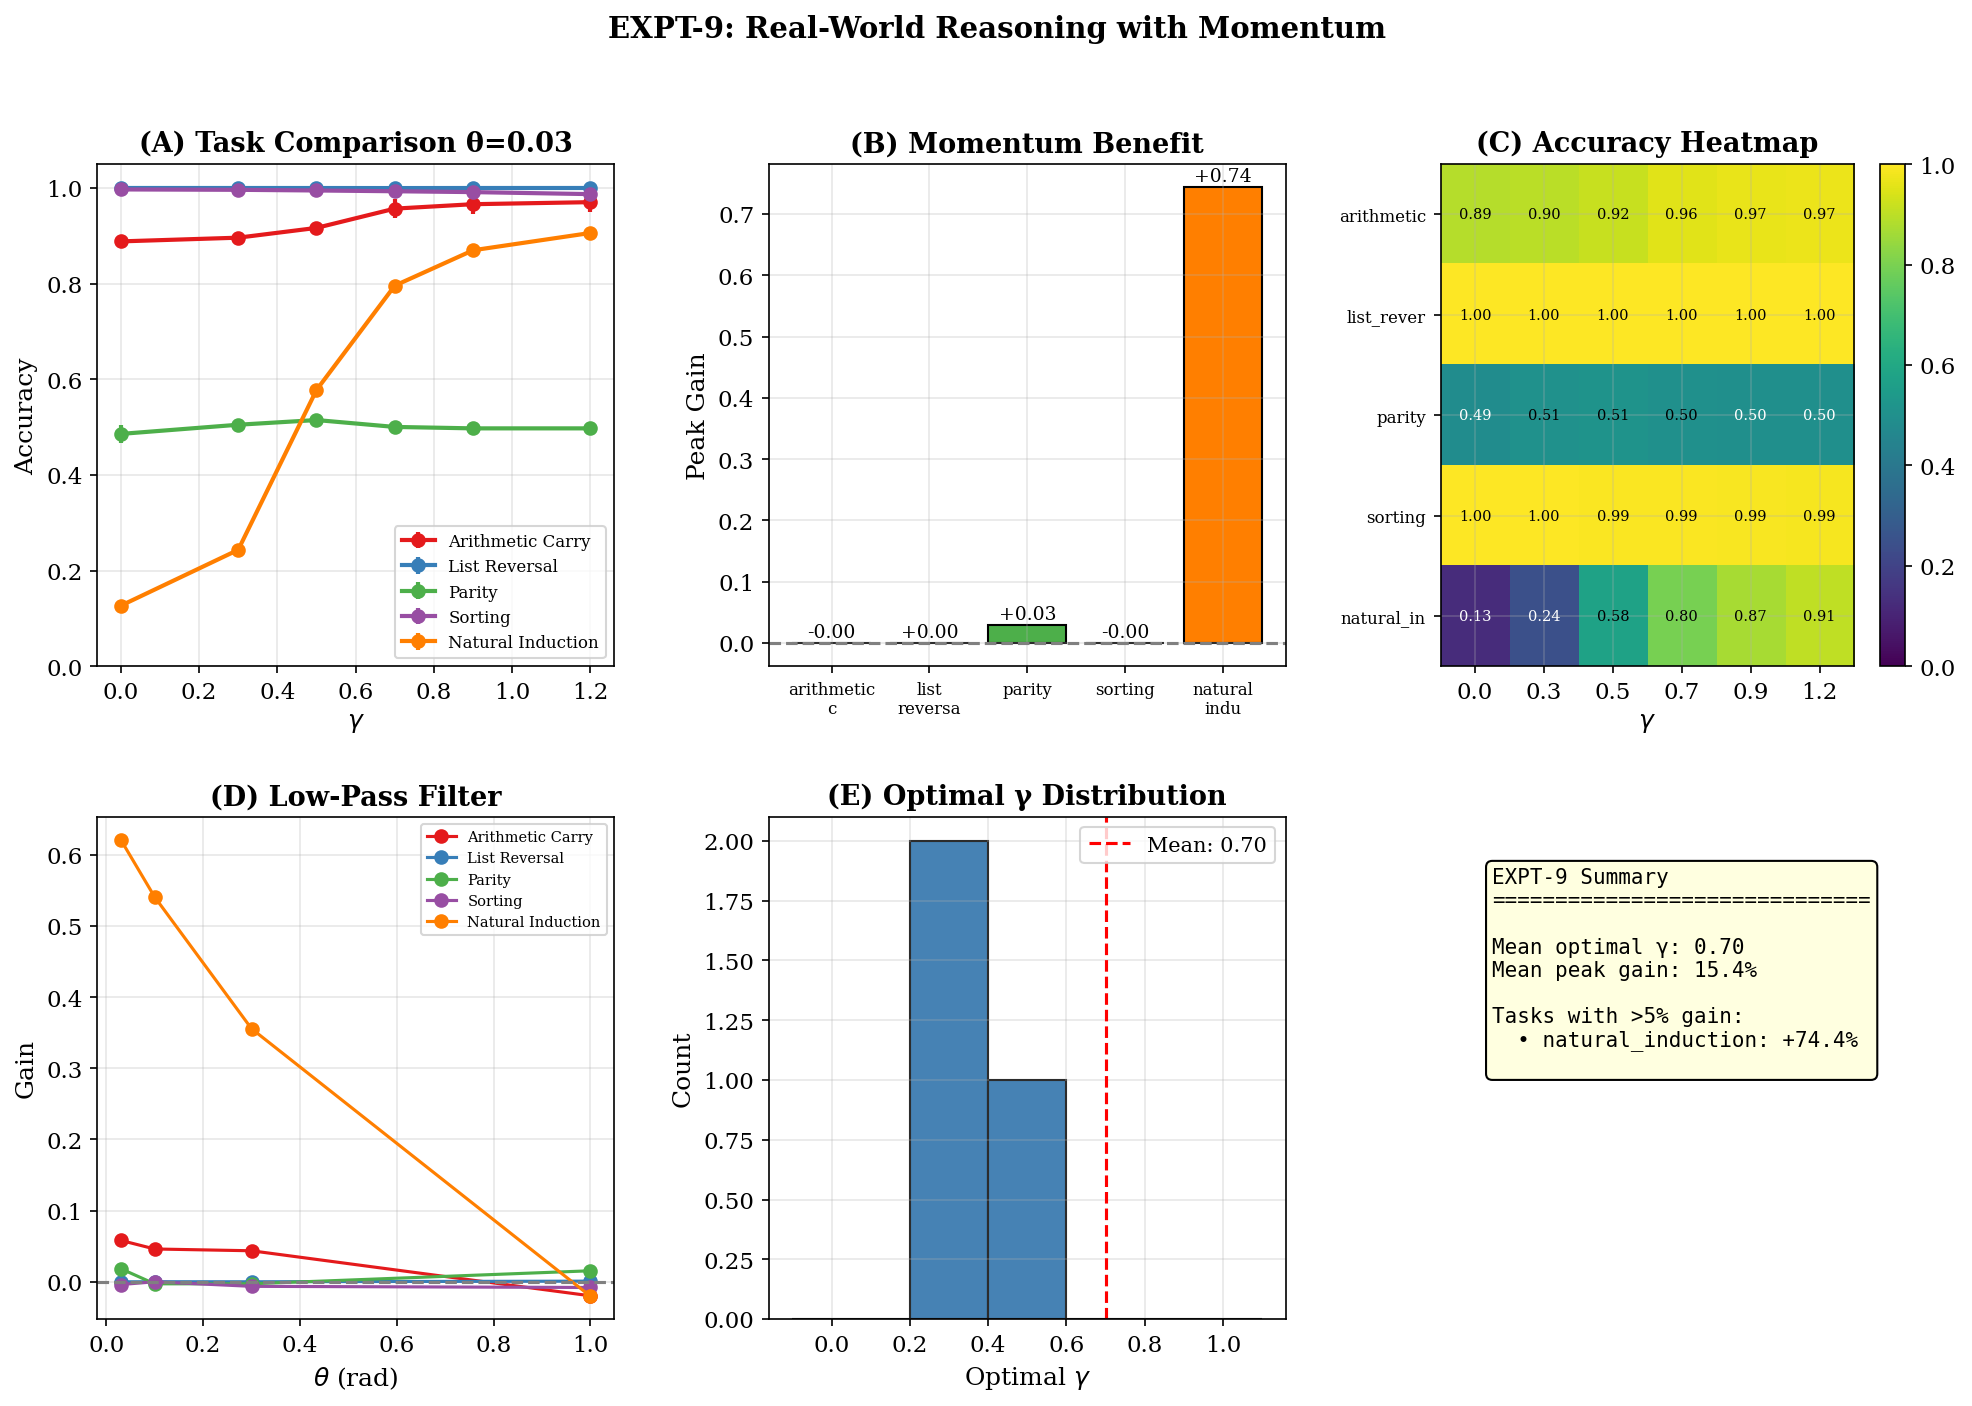

Figure 1 saved


In [ ]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Panel A: U-curves at best theta
ax = fig.add_subplot(gs[0,0])
for task in cfg.tasks:
    td = df_agg[(df_agg['task']==task) & (df_agg['theta']==0.03)]
    if len(td):
        ax.errorbar(td['gamma'], td['mean_acc'], yerr=td['sem_acc'],
                   fmt='o-', color=TASK_COLORS.get(task,'gray'), lw=2,
                   label=task.replace('_',' ').title())
ax.set_xlabel(r'$\gamma$'); ax.set_ylabel('Accuracy')
ax.set_title('(A) Task Comparison θ=0.03'); ax.legend(fontsize=8)
ax.set_ylim([0,1.05])

# Panel B: Peak gains
ax = fig.add_subplot(gs[0,1])
tasks = df_sum['task'].tolist()
gains = df_sum['peak_gain'].tolist()
colors = [TASK_COLORS.get(t,'gray') for t in tasks]
bars = ax.bar(range(len(tasks)), gains, color=colors, edgecolor='black')
ax.set_xticks(range(len(tasks)))
ax.set_xticklabels([t.replace('_','\n')[:12] for t in tasks], fontsize=8)
ax.axhline(0, color='gray', ls='--')
ax.set_ylabel('Peak Gain'); ax.set_title('(B) Momentum Benefit')
for b,g in zip(bars,gains): ax.text(b.get_x()+b.get_width()/2, g+0.01, f'{g:+.2f}',
                                     ha='center', fontsize=9)

# Panel C: Heatmap
ax = fig.add_subplot(gs[0,2])
piv = df_agg[df_agg['theta']==0.03].pivot(index='task', columns='gamma', values='mean_acc')
piv = piv.reindex(cfg.tasks)
im = ax.imshow(piv.values, cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax.set_xticks(range(len(piv.columns))); ax.set_xticklabels([f'{g:.1f}' for g in piv.columns])
ax.set_yticks(range(len(piv.index))); ax.set_yticklabels([t[:10] for t in piv.index], fontsize=8)
ax.set_xlabel(r'$\gamma$'); ax.set_title('(C) Accuracy Heatmap')
for i in range(len(piv.index)):
    for j in range(len(piv.columns)):
        v = piv.values[i,j]
        if not np.isnan(v):
            ax.text(j,i,f'{v:.2f}',ha='center',va='center',color='w' if v<0.5 else 'k',fontsize=7)
plt.colorbar(im, ax=ax)

# Panel D: Low-pass filter
ax = fig.add_subplot(gs[1,0])
for task in cfg.tasks:
    td = df_agg[(df_agg['task']==task) & (df_agg['gamma']>=0.5) & (df_agg['gamma']<=1.0)]
    if len(td):
        tg = td.groupby('theta')['gain'].mean()
        ax.plot(tg.index, tg.values, 'o-', color=TASK_COLORS.get(task,'gray'),
               label=task.replace('_',' ').title())
ax.axhline(0, color='gray', ls='--')
ax.set_xlabel(r'$\theta$ (rad)'); ax.set_ylabel('Gain')
ax.set_title('(D) Low-Pass Filter'); ax.legend(fontsize=7)

# Panel E: Optimal gamma hist
ax = fig.add_subplot(gs[1,1])
opt_gs = df_sum['opt_gamma'].values
ax.hist(opt_gs, bins=np.array(cfg.gamma_values)-0.1, color='steelblue', edgecolor='black')
ax.axvline(np.mean(opt_gs), color='red', ls='--', label=f'Mean: {np.mean(opt_gs):.2f}')
ax.set_xlabel(r'Optimal $\gamma$'); ax.set_ylabel('Count')
ax.set_title('(E) Optimal γ Distribution'); ax.legend()

# Panel F: Summary
ax = fig.add_subplot(gs[1,2]); ax.axis('off')
txt = f"""EXPT-9 Summary
{'='*30}

Mean optimal γ: {df_sum['opt_gamma'].mean():.2f}
Mean peak gain: {df_sum['peak_gain'].mean():.1%}

Tasks with >5% gain:
"""
for _,r in df_sum.iterrows():
    if r['peak_gain'] > 0.05:
        txt += f"  • {r['task']}: +{r['peak_gain']:.1%}\n"
ax.text(0.1, 0.9, txt, transform=ax.transAxes, fontsize=10, va='top', family='monospace',
       bbox=dict(boxstyle='round', facecolor='lightyellow'))

plt.suptitle('EXPT-9: Real-World Reasoning with Momentum', fontsize=14, fontweight='bold')
plt.savefig('fig1_expt9.png', dpi=300, bbox_inches='tight')
plt.savefig('fig1_expt9.pdf', bbox_inches='tight')
plt.show()
print('Figure 1 saved')

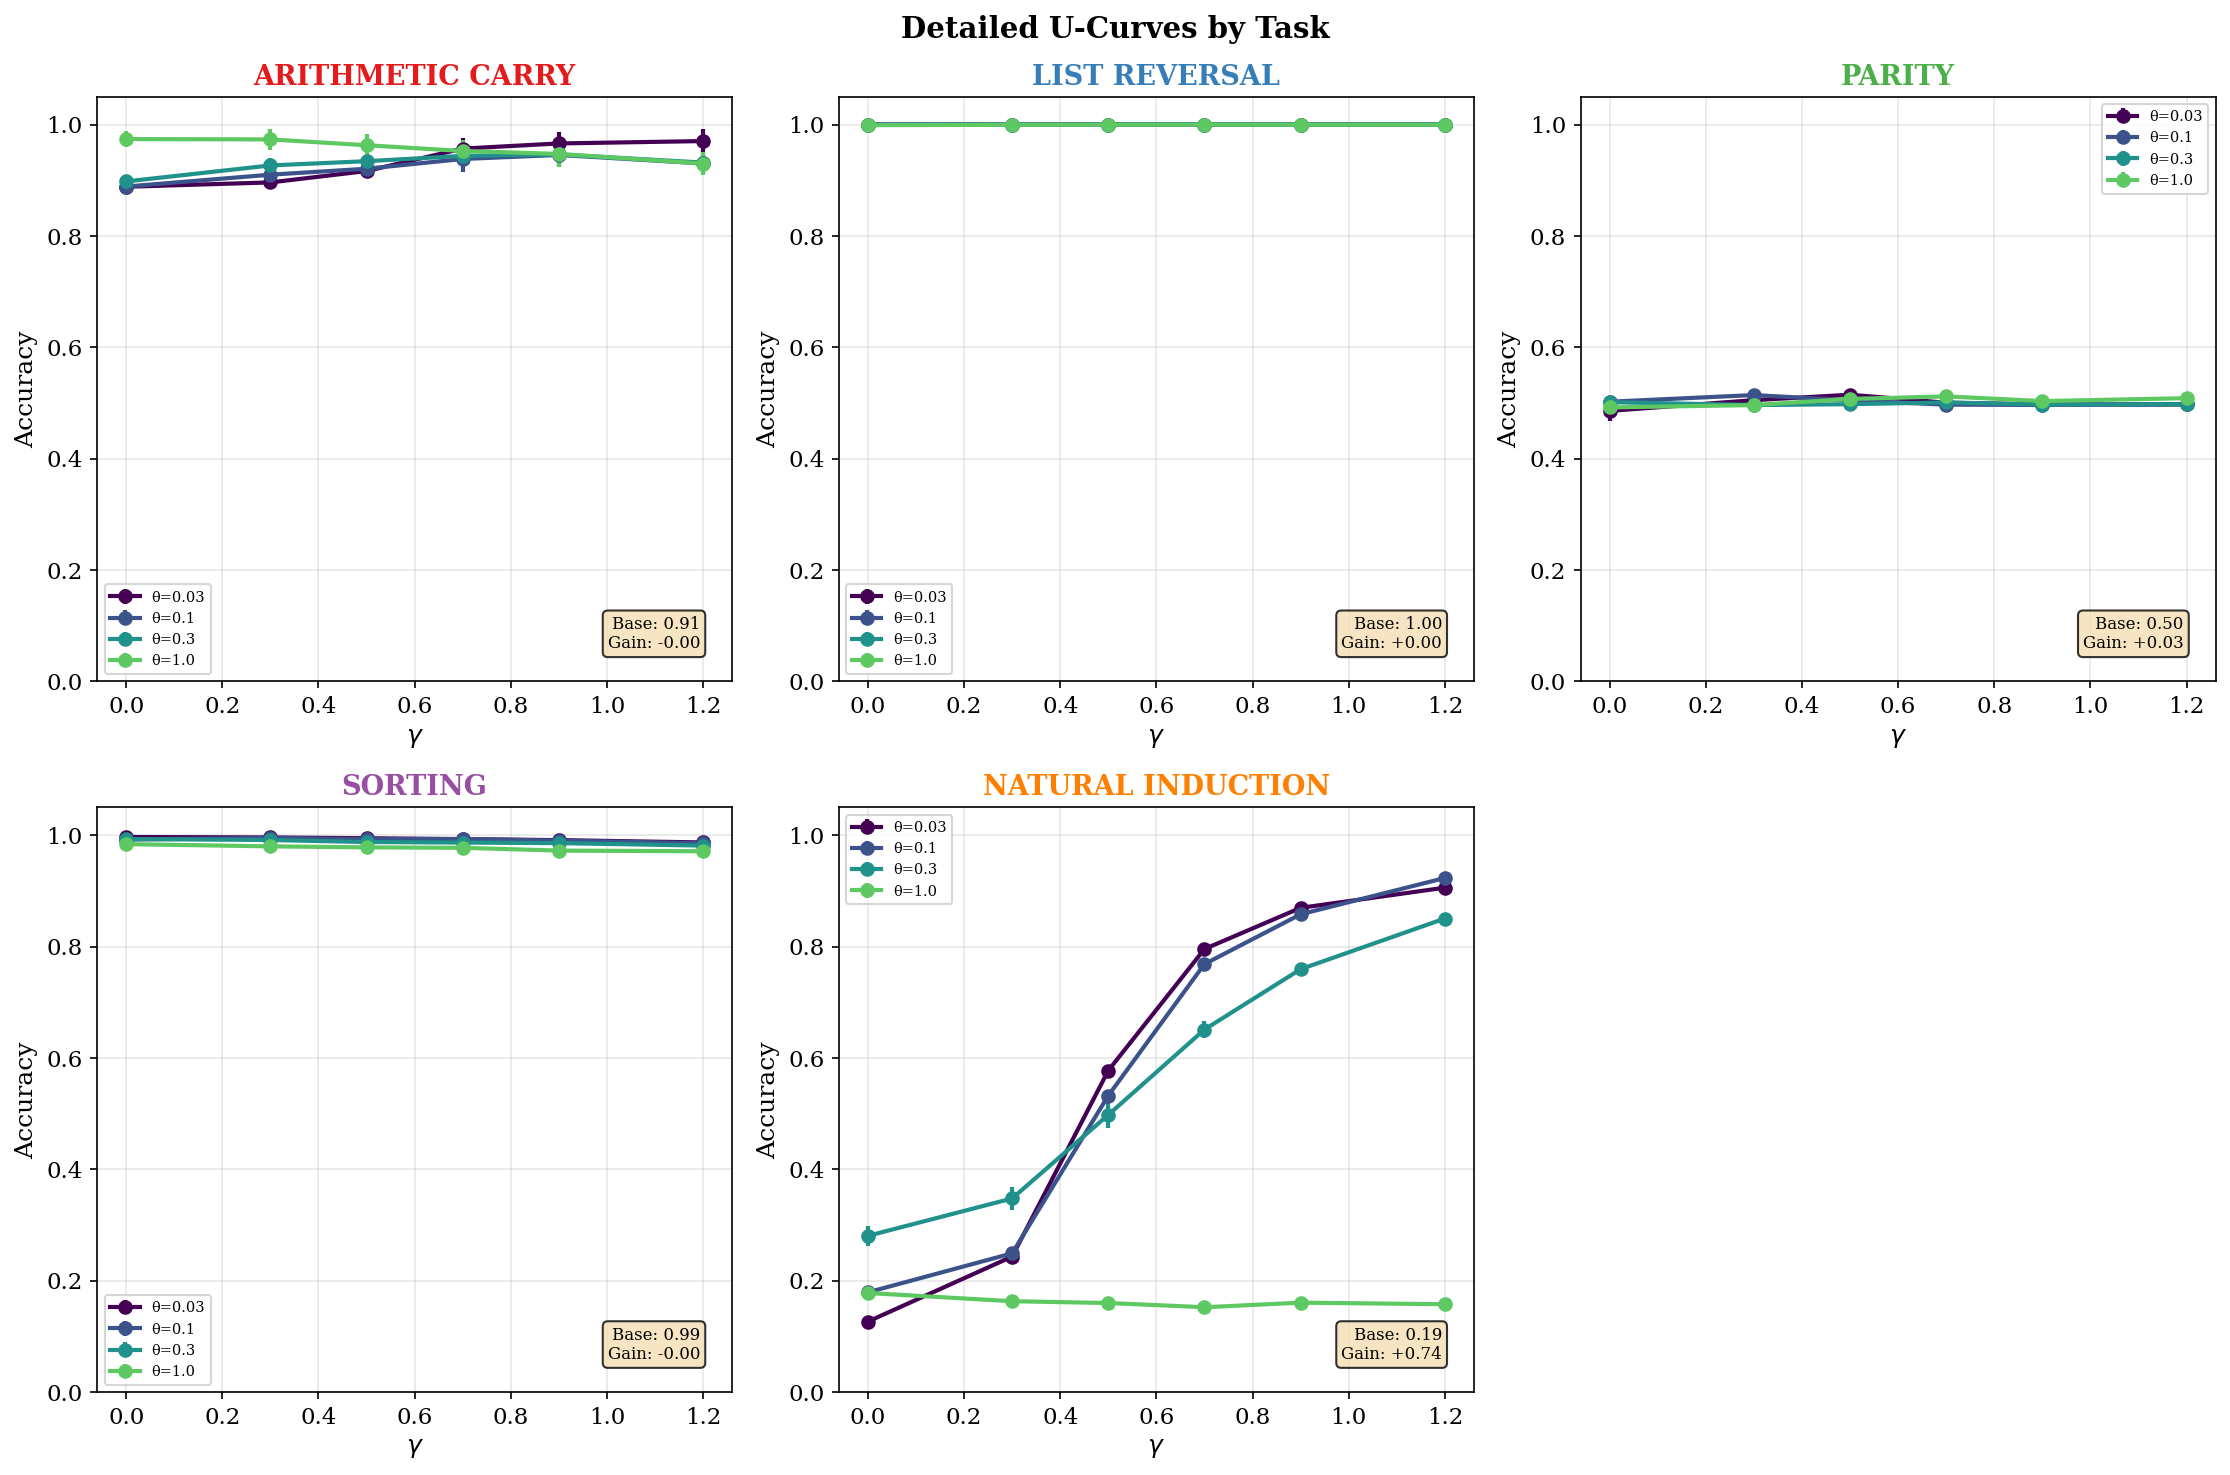

Figure 2 saved


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, task in enumerate(cfg.tasks):
    ax = axes[idx]
    td = df_agg[df_agg['task']==task]
    for i, theta in enumerate(cfg.theta_values):
        tt = td[td['theta']==theta]
        if len(tt):
            c = plt.cm.viridis(i/len(cfg.theta_values))
            ax.errorbar(tt['gamma'], tt['mean_acc'], yerr=tt['sem_acc'],
                       fmt='o-', color=c, lw=2, label=f'θ={theta}')
    ax.set_xlabel(r'$\gamma$'); ax.set_ylabel('Accuracy')
    ax.set_title(task.replace('_',' ').upper(), color=TASK_COLORS.get(task,'black'))
    ax.legend(fontsize=7); ax.set_ylim([0,1.05])
    sr = df_sum[df_sum['task']==task].iloc[0]
    ax.text(0.95, 0.05, f"Base: {sr['baseline']:.2f}\nGain: {sr['peak_gain']:+.2f}",
           transform=ax.transAxes, ha='right', va='bottom', fontsize=8,
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

if len(cfg.tasks) < 6: axes[-1].axis('off')
plt.suptitle('Detailed U-Curves by Task', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig2_expt9.png', dpi=300, bbox_inches='tight')
plt.savefig('fig2_expt9.pdf', bbox_inches='tight')
plt.show()
print('Figure 2 saved')

In [ ]:
print('\n' + '='*60)
print('FINAL SUMMARY')
print('='*60)

for _, r in df_sum.iterrows():
    g = r['peak_gain']
    em = '🟢' if g > 0.1 else ('🟡' if g > 0.03 else '⚪')
    print(f"{em} {r['task']:<20}: base={r['baseline']:.3f}, peak={r['peak_acc']:.3f}, "
          f"gain={g:+.3f}, γ*={r['opt_gamma']:.1f}")

avg_gain = df_sum['peak_gain'].mean()
mean_g = df_sum['opt_gamma'].mean()

print('\nHypothesis Tests:')
print(f"  H1 (gain > 5%): {'✓' if avg_gain > 0.05 else '✗'} ({avg_gain:.1%})")
print(f"  H2 (γ ≈ 0.7-0.9): {'✓' if 0.5 < mean_g < 1.2 else '✗'} ({mean_g:.2f})")
print(f"  H3 (task-dependent): {'✓' if df_sum['peak_gain'].std() > 0.05 else '✗'}")

print('\nOutput files:')
print('  • expt9_raw.csv, expt9_agg.csv, expt9_results.json')
print('  • fig1_expt9.png/.pdf, fig2_expt9.png/.pdf')

print('\n' + '='*60)
if avg_gain > 0.05:
    print('🎉 MOMENTUM VALIDATED ON REAL-WORLD REASONING!')
else:
    print('⚠️ Results require further investigation')
print('='*60)


FINAL SUMMARY
⚪ arithmetic_carry    : base=0.912, peak=0.974, gain=-0.001, γ*=0.3
⚪ list_reversal       : base=1.000, peak=1.000, gain=+0.000, γ*=1.2
⚪ parity              : base=0.495, peak=0.515, gain=+0.029, γ*=0.5
⚪ sorting             : base=0.992, peak=0.997, gain=-0.001, γ*=0.3
🟢 natural_induction   : base=0.191, peak=0.923, gain=+0.744, γ*=1.2

Hypothesis Tests:
  H1 (gain > 5%): ✓ (15.4%)
  H2 (γ ≈ 0.7-0.9): ✓ (0.70)
  H3 (task-dependent): ✓

Output files:
  • expt9_raw.csv, expt9_agg.csv, expt9_results.json
  • fig1_expt9.png/.pdf, fig2_expt9.png/.pdf

🎉 MOMENTUM VALIDATED ON REAL-WORLD REASONING!
